In [1]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "retina"

In [2]:
%pwd

'/Users/kpmurphy/github/bong/bong/experiments'

In [1]:
from kpm_linreg import *

print(AGENT_TYPES)


['fg-bong', 'fg-l-bong', 'fg-rep-bong', 'fg-rep-l-bong', 'fg-blr', 'fg-bog', 'fg-rep-bog', 'fg-bbb', 'fg-rep-bbb']


making  fg-blr-MC100-LR0_005
making  fg-blr-MC100-LR0_01
making  fg-blr-MC100-LR0_05
making  fg-blr-MC100-LR0_1
making  fg-bog-MC100-LR0_005
making  fg-bog-MC100-LR0_01
making  fg-bog-MC100-LR0_05
making  fg-bog-MC100-LR0_1
making  fg-bbb-MC100-LR0_005
making  fg-bbb-MC100-LR0_01
making  fg-bbb-MC100-LR0_05
making  fg-bbb-MC100-LR0_1
Running fg-bong-MC100...
	KL-Div: 0.0172, Time: 0.52s
Running fg-blr-MC100-LR0_005...
	KL-Div: 1.6179, Time: 1.43s
Running fg-blr-MC100-LR0_01...
	KL-Div: 0.4489, Time: 1.45s
Running fg-blr-MC100-LR0_05...
	KL-Div: 0.0070, Time: 1.45s
Running fg-blr-MC100-LR0_1...
	KL-Div: 0.0027, Time: 1.41s
Running fg-bog-MC100-LR0_005...
	KL-Div: 16.3941, Time: 0.44s
Running fg-bog-MC100-LR0_01...
	KL-Div: 15.1897, Time: 0.45s
Running fg-bog-MC100-LR0_05...
	KL-Div: nan, Time: 0.45s
Running fg-bog-MC100-LR0_1...
	KL-Div: nan, Time: 0.45s
Running fg-bbb-MC100-LR0_005...
	KL-Div: 9.3828, Time: 1.61s
Running fg-bbb-MC100-LR0_01...
	KL-Div: 8.7102, Time: 1.54s
Running fg-bb

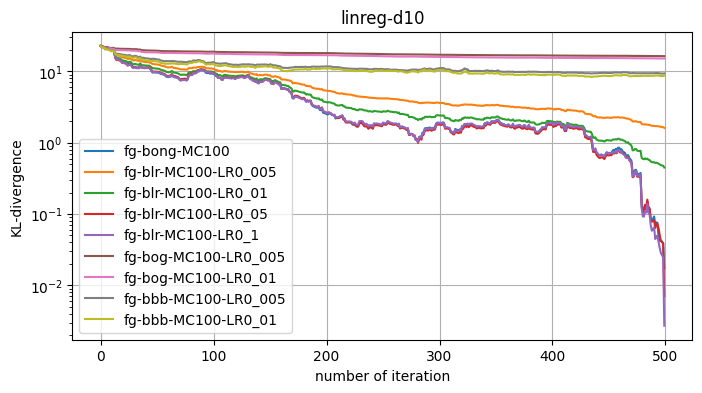

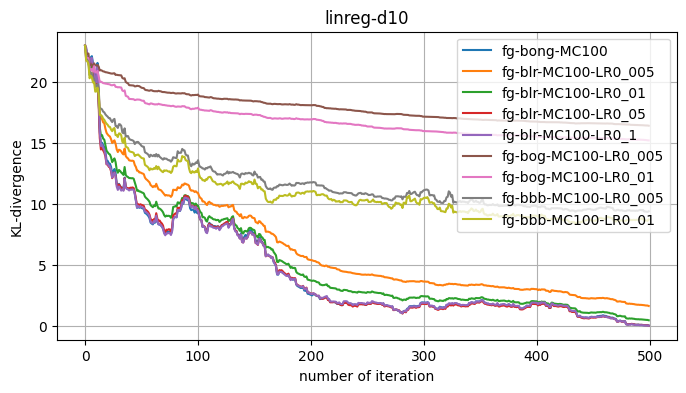

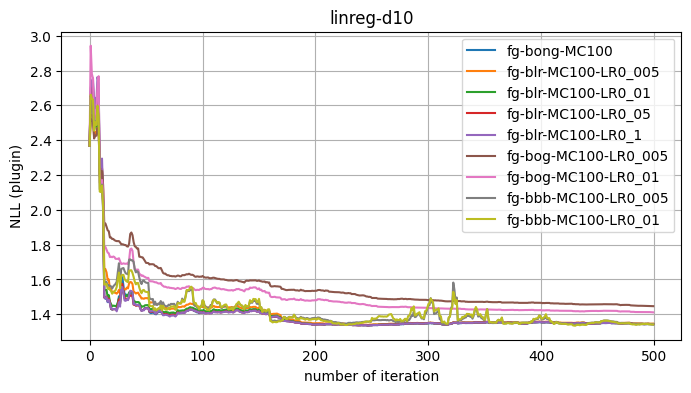

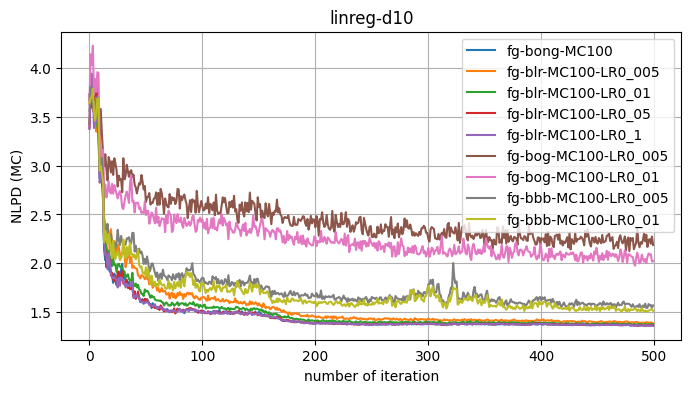

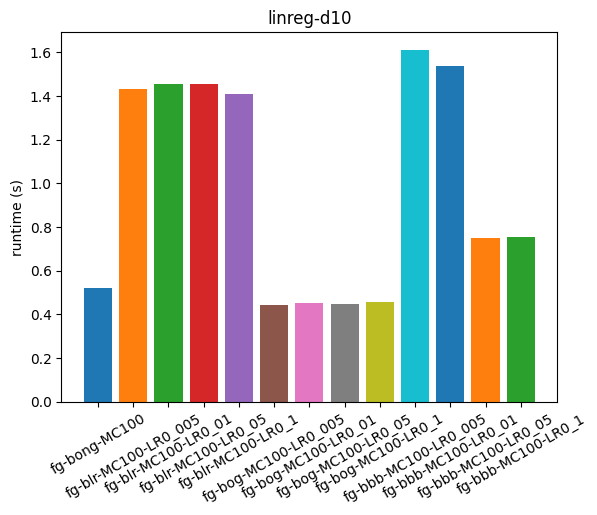

In [2]:
#python experiments/s01_linreg.py --agents fg-bong fg-l-bong --num_samples 10 100

parser = argparse.ArgumentParser()
    
  # Data parameters
parser.add_argument("--num_examples", type=int, default=500)
parser.add_argument("--param_dim", type=int, default=10)
parser.add_argument("--key", type=int, default=0)
parser.add_argument("--emission_noise", type=float, default=1.0)

# Model parameters
parser.add_argument("--agents", type=str, nargs="+",
                    default=["fg-bong", "fg-blr", "fg-bog", "fg-bbb"], choices=AGENT_TYPES)
parser.add_argument("--num_samples", type=int, nargs="+", 
                    default=[100])
parser.add_argument("--learning_rate", type=int, nargs="+", 
                    default=[0.005, 0.01, 0.02])
parser.add_argument("--tune_learning_rate", type=bool, default=False)

#https://stackoverflow.com/questions/30656777/how-to-call-module-written-with-argparse-in-ipython-notebook
#args = parser.parse_args()
args = parser.parse_args(args=[])

main(args)


In [7]:
%pwd

'/Users/kpmurphy/github/bong/bong/experiments'

In [6]:
lr = 0.01
lr_str = f"{lr}".replace('.', '_')
print(lr_str)


0_01
